#Colab Installations

In [1]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 922.2/922.2 kB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 34.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 19.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 28.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 9.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 54.0 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstallin

In [2]:
!pip install git+https://github.com/openai/CLIP.git

  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-e4awe2sk
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-e4awe2sk
  Resolved https://github.com/openai/CLIP.git to commit dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 2.3 MB/s eta 0:00:00
  Created wheel for clip: filename=clip-1.0-py3-none-any.whl size=1369489 sha256=48d0f7d723dc9d665f1220eeccf8eddc916f0f1efbb39fbf8cf42f6a32e5be8a
  Stored in directory: /tmp/pip-ephem-wheel-cache-xfqs3crn/wheels/3f/7c/a4/9b490845988bf7a4db33674d52f709f088f64392063872eb9a
Successfully built clip


#Imports

In [8]:
import torch
import torch.nn.functional as F
import torchvision.models as models
import torchvision.transforms as T
import numpy as np
import os
import time
import cv2
import clip
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw, ImageOps, ImageEnhance
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from mpl_toolkits.mplot3d import Axes3D
from ultralytics import YOLO
from typing import List
from torchvision.ops import roi_align
from typing import Optional
import logging
import sys

Set Loggings

In [9]:
# Remove any previous logging handlers to avoid duplicates
for handler in logging.root.handlers[:]:
    logging.root.removeHandler(handler)

# Configure logging
logging.basicConfig(
    level=logging.INFO,
    format=" %(message)s",
    handlers=[logging.StreamHandler(sys.stdout)]
)

# Validates that Colab/Jupyter does not suppress logs
logging.getLogger().setLevel(logging.INFO)

#Object Embedder System

In [10]:
class ObjectEmbedder:
    """
    Object embedding class supporting both:
    - YOLO with RoIAlign-based embeddings.
    - Cropped object embeddings using ResNet50 or CLIP.
    """

    def __init__(
        self,
        detection_model: str = "yolo12x",
        embed_method: str = "roi_align",
        crop_backbone: str = "resnet50",
        conf_threshold: float = 0.6,
        target_classes: Optional[list[str]] = None
    ):
        """
        Initializes the object embedder.

        Args:
            detection_model (str): The object detection model (YOLO version).
            embed_method (str): Embedding method ("roi_align" or "crop").
            crop_backbone (str): Backbone model for cropped object embeddings ("resnet50" or "clip").
            conf_threshold (float): Confidence threshold for detection.
            target_classes (list[str], optional): List of class names to filter detections.
        """
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.embed_method = embed_method
        self.conf_threshold = conf_threshold
        self.crop_backbone_name = crop_backbone

        # Load models
        self.detector = self._load_detector(detection_model)
        self.backbone = self._load_backbone()

        # Image Preprocessing
        self.transform = self._get_transform()

        # Set target class mappings
        self.target_classes = self._set_target_classes(target_classes)

    ##### Private Functions for Initialization
    def _load_detector(self, detection_model: str) -> torch.nn.Module:
        """Loads and returns the YOLO detection model."""
        detector = YOLO(f"{detection_model}.pt", verbose=False).to(self.device)
        detector.fuse()  # Optimize YOLO for inference
        return detector

    def _load_backbone(self) -> torch.nn.Module:
        """Loads and returns the embedding backbone model."""
        if self.embed_method == "crop":
            return self._load_crop_backbone()
        elif self.embed_method == "roi_align":
            return self._load_roi_backbone()
        else:
            raise ValueError(f"Unsupported embedding method: {self.embed_method}")

    def _load_crop_backbone(self) -> torch.nn.Module:
        """Loads backbone model for cropped embeddings."""
        if self.crop_backbone_name == "resnet50":
            backbone = models.resnet50(pretrained=True).to(self.device)
            backbone = torch.nn.Sequential(*list(backbone.children())[:-1])  # Remove FC layer
            return backbone.eval()  # Evaluation mode

        elif self.crop_backbone_name == "clip":
            backbone, self.preprocess = clip.load("ViT-B/32", device=self.device) # CLIP returns the model and the relvant pre-process of the input
            return backbone.eval()  # Evaluation mode
        else:
            raise ValueError(f"Unsupported crop_backbone: {self.crop_backbone_name}")

    def _load_roi_backbone(self) -> torch.nn.Module:
        """Loads backbone model for RoIAlign embeddings."""
        backbone = models.resnet50(pretrained=True).to(self.device)
        return torch.nn.Sequential(*list(backbone.children())[:-4])  # Extract intermediate feature map

    def _get_transform(self) -> T.Compose:
        """Returns the appropriate image transformation pipeline."""
        if self.crop_backbone_name == "clip":
            return self.preprocess
        return T.Compose([
            T.Lambda(lambda img: ImageOps.pad(img, (max(img.size), max(img.size)), color=(0, 0, 0))),  # Ensure square images
            T.Resize((224, 224), interpolation=T.InterpolationMode.BICUBIC),  # Resize with smooth interpolation (sice reiszing my harm the pixels of the crops)
            T.ToTensor(),
            T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize to ImageNet mean and std values
        ])

    def _set_target_classes(self, target_classes: Optional[List[str]]) -> Optional[List[int]]:
        """Maps class names to indices and returns filtered class list."""
        self.class_names = self.detector.model.names if hasattr(self.detector.model, "names") else {}
        self.class_name_to_idx = {v: k for k, v in self.class_names.items()}

         # If target_classes is None or empty, return None
        if not target_classes:
            return None

        # Convert class names to indices, filtering out invalid ones
        target_class_indices = [self.class_name_to_idx[name] for name in target_classes if name in self.class_name_to_idx]

        return target_class_indices if target_class_indices else None  # Ensure it returns None if no valid classes found

    ##### End of private function for initialization

    # Function that relvant for call function's process
    def detect_objects(self, image: Image.Image) -> torch.Tensor:
        """
        Detects objects using YOLO and returns bounding boxes.

        Args:
            image (PIL.Image): Input image.

        Returns:
            torch.Tensor: Tensor of shape (k, 6) -> [x1, y1, x2, y2, confidence, class]
        """
        results = self.detector(image, conf=self.conf_threshold, verbose=False) #apply YOLO on the image
        if not results[0].boxes:
            return torch.empty((0, 6), device=self.device)

        detections = torch.cat([
            results[0].boxes.xyxyn, # Normalized bounding box coordinates
            results[0].boxes.conf.unsqueeze(1), # Confidence scorres
            results[0].boxes.cls.unsqueeze(1) ## Class Label ID
        ], dim=1).to(self.device)

        if self.target_classes is not None:
            mask = torch.isin(detections[:, -1], torch.tensor(self.target_classes, device=self.device))
            detections = detections[mask] # Filter detection of for relvant class only if needed

        return detections if detections.shape[0] > 0 else torch.empty((0, 6), device=self.device)

    def extract_embeddings(self, image: Image.Image, detections: torch.Tensor) -> torch.Tensor:
        """
        Extracts object embeddings.

        Args:
            image (PIL.Image): Input image.
            detections (torch.Tensor): Bounding boxes tensor.

        Returns:
            torch.Tensor: Embeddings tensor (k, n)
        """
        return (
            self.extract_roi_align_embeddings(image, detections)
            if self.embed_method == "roi_align"
            else self.extract_crop_embeddings(image, detections)
        )

    def extract_roi_align_embeddings(self, image: Image.Image, detections: torch.Tensor) -> torch.Tensor:
        """
        Extract object embeddings using RoIAlign.

        Args:
            image (PIL.Image): Input image.
            detections (torch.Tensor): Bounding boxes tensor.

        Returns:
            torch.Tensor: Embeddings tensor (k, 2048)
        """

        image_tensor = self.transform(image).unsqueeze(0).to(self.device)
        with torch.no_grad():
            feature_map = self.backbone(image_tensor) #Get the feature map of the image

        # Convert normalized bbox to feature map coordinates
        abs_boxes = torch.cat([
            torch.zeros(detections.shape[0], 1, device=self.device),  # Batch index (all 0s since single image)
            detections[:, :4] * torch.tensor([feature_map.shape[3], feature_map.shape[2],
                                                feature_map.shape[3], feature_map.shape[2]], device=self.device)  # Scale x1, y1, x2, y2
        ], dim=1)

        # Clamp bounding box coordinates to prevent out-of-range errors
        abs_boxes[:, 1::2] = torch.clamp(abs_boxes[:, 1::2], min=0, max=feature_map.shape[2])  # y1, y2
        abs_boxes[:, 0::2] = torch.clamp(abs_boxes[:, 0::2], min=0, max=feature_map.shape[3])  # x1, x2

        # Apply ROI Align to extract object features
        feature_patch = (14, 14)
        pooled_features = roi_align(feature_map, abs_boxes, output_size=feature_patch)  # Shape: [num_objects, Embedding_Dim, 14, 14]
        pooled_features = F.adaptive_max_pool2d(pooled_features, (1, 1))  # Reduce to [num_objects, Embedding_Dim, 1, 1]
        embeddings_tensor = pooled_features.view(len(detections), -1)  # Flatten to (k, Embedding_Dim)

        return embeddings_tensor.cpu()  # Shape: (num_objects, Embedding_Dim), Embedding_Dim is 512 currently

    def extract_crop_embeddings(self, image: Image.Image, detections: torch.Tensor) -> torch.Tensor:
        """
        Extract embeddings by cropping detected objects and passing them through ResNet50 or CLIP.

        Args:
            image (PIL.Image): Input image.
            detections (torch.Tensor): Bounding boxes tensor.

        Returns:
            torch.Tensor: Embeddings tensor (k, embedding_dim)
        """
        img_w, img_h = image.size

        # Convert normalized bbox coordinates to absolute image coordinates
        boxes_abs = detections[:, :4].clone() * torch.tensor([img_w, img_h, img_w, img_h], device=self.device)

        # Clamp values to keep bounding boxes inside image dimensions
        boxes_abs[:, 0::2] = torch.clamp(boxes_abs[:, 0::2], min=0, max=img_w)  # Clamp x1, x2
        boxes_abs[:, 1::2] = torch.clamp(boxes_abs[:, 1::2], min=0, max=img_h)  # Clamp y1, y2
        boxes_abs = boxes_abs.round().int().tolist()

        # Crop images with the adjusted bounding boxes
        cropped_images = [image.crop((x1, y1, x2, y2)) for x1, y1, x2, y2 in boxes_abs]
        if not cropped_images:
            return torch.empty((0, 512), device=self.device)

        cropped_tensors = torch.stack([self.transform(img) for img in cropped_images]).to(self.device) # Transform crops tensors
        with torch.no_grad():  # Apply backbone on crops in batch
          if self.crop_backbone_name == "clip":
              embeddings = self.backbone.encode_image(cropped_tensors).cpu()
          else: #currently ResNet50 Backbone
              embeddings = self.backbone(cropped_tensors).squeeze(-1).squeeze(-1).cpu()


        return embeddings

    #The main call function
    def __call__(self, image: Image.Image) -> tuple[torch.Tensor, torch.Tensor]:
        """
        return type should be:
        tuple of - torch.Tensor of shape (k, 6) where k is the number of objects detected
        6 is the number of attributes of each object: [x1, y1, x2, y2, confidence, class]
        xyxy is normalized. (0, 0) is top-left and (1, 1) is bottom-right - torch.Tensor of shape (k,n) where k is the number of objects detected
        and n is the dimension of your embedding space
        """
        #get detections
        detections = self.detect_objects(image)
        if detections.shape[0] > 0:
            embeddings = self.extract_embeddings(image, detections) #Exctract objects embeddings
        else:
            embeddings = torch.empty((0, 256))

        return detections.cpu(), F.normalize(embeddings, p=2, dim=1) #normalize the embeddings


    ### Visualization Functions
    def _prepare_embeddings_and_labels(self, embeddings_list: List[torch.Tensor], detections_list: List[torch.Tensor]) -> tuple[np.ndarray, np.ndarray]:
        """
        Helper function to process embeddings and labels from multiple images.

        Args:
            embeddings_list (List[torch.Tensor]): List of embedding tensors.
            detections_list (List[torch.Tensor]): List of detection tensors.

        Returns:
            Tuple[np.ndarray, np.ndarray]: Processed embeddings and labels.
        """
        if not embeddings_list or not detections_list:
            logging.warning("No embeddings or detections provided.")
            return np.empty((0, 512)), np.empty(0)

        # Merge embeddings and labels
        all_embeddings = torch.cat(embeddings_list, dim=0).cpu().numpy()
        all_labels = torch.cat(detections_list, dim=0).cpu()[:, -1].numpy()

        if all_embeddings.shape[0] == 0:
            logging.warning("No objects detected in any image.")
            return np.empty((0, 512)), np.empty(0)

        # Filter embeddings if target_classes is specified
        if self.target_classes:
            mask = np.isin(all_labels, self.target_classes)
            if not np.any(mask):  # Check if any target classes exist
                logging.warning("No objects detected for the specified target classes.")
                return np.empty((0, 512)), np.empty(0)
            all_embeddings, all_labels = all_embeddings[mask], all_labels[mask]

        logging.info(f"Processed {len(all_embeddings)} embeddings after filtering.")

        return all_embeddings, all_labels


    def _generate_legend(self, unique_classes: np.ndarray, cmap: plt.cm) -> list:
        """
        Helper function to generate a legend for class names and colors.

        Args:
            unique_classes (np.ndarray): Unique class labels.
            cmap (matplotlib colormap): Colormap used for visualization.

        Returns:
            List: Legend patches for the plot.
        """
        # Mapping for each class a specific color
        class_to_color = {cls: cmap(i) for i, cls in enumerate(unique_classes)}
        legend_patches = [
            plt.Line2D([0], [0], marker="o", color="w", markerfacecolor=color, markersize=8,
                      label=self.class_names.get(int(cls), f"Class {int(cls)}"))
            for cls, color in class_to_color.items()
        ] # Creating a legend patch with the relevant info
        return legend_patches, class_to_color

    def visualize_emb_tSNE(self, embeddings_list: list[torch.Tensor], detections_list: list[torch.Tensor]) -> None:
        """
        Generates a t-SNE visualization for embeddings from multiple images.

        Args:
            embeddings_list (list[torch.Tensor]): List of embedding tensors.
            detections_list (list[torch.Tensor]): List of detection tensors.

        Returns:
            None (Displays a plot).
        """
        all_embeddings, all_labels = self._prepare_embeddings_and_labels(embeddings_list, detections_list)
        if all_embeddings.size == 0:
            return

        # Ensure valid perplexity for t-SNE
        perplexity = min(30, max(2, len(all_embeddings) - 1)) # Adjust perplexity if the data is minimal (few images with few objects)

        # Apply t-SNE for dimensionality reduction
        tsne = TSNE(n_components=2, random_state=42, perplexity=perplexity)
        embeddings_2d = tsne.fit_transform(all_embeddings)

        # Assign colors dynamically for detected classes
        unique_classes = np.unique(all_labels)
        cmap = plt.get_cmap("coolwarm", len(unique_classes))
        legend_patches, class_to_color = self._generate_legend(unique_classes, cmap)

        # Ploting the results
        plt.figure(figsize=(8, 6))
        plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=[class_to_color[cls] for cls in all_labels], alpha=0.7)
        plt.xlabel("t-SNE Dimension 1")
        plt.ylabel("t-SNE Dimension 2")
        plt.title("t-SNE of Object Embeddings")
        plt.legend(handles=legend_patches, title="Class Name")
        plt.show()

    def visualize_pca_3D(self, embeddings_list: list[torch.Tensor], detections_list: list[torch.Tensor]) -> None:
        """
        Plots 3D PCA of object embeddings for better class separation visualization.

        Args:
            embeddings_list (list[torch.Tensor]): List of embedding tensors.
            detections_list (list[torch.Tensor]): List of detection tensors.

        Returns:
            None (Displays a plot).
        """
        all_embeddings, all_labels = self._prepare_embeddings_and_labels(embeddings_list, detections_list)
        if all_embeddings.size == 0:
            return

        # Apply PCA for dimentionality reduction
        pca = PCA(n_components=3)
        embeddings_3d = pca.fit_transform(all_embeddings)

        # Assign colors dynamically for detected classes
        unique_classes = np.unique(all_labels)
        cmap = plt.get_cmap("coolwarm", len(unique_classes))
        legend_patches, class_to_color = self._generate_legend(unique_classes, cmap)

        # Plot the results
        fig = plt.figure(figsize=(10, 7))
        ax = fig.add_subplot(111, projection="3d")
        ax.scatter(embeddings_3d[:, 0], embeddings_3d[:, 1], embeddings_3d[:, 2], c=[class_to_color[cls] for cls in all_labels], alpha=0.7)

        plt.legend(handles=legend_patches, title="Class Name")
        ax.set_xlabel("PCA Component 1")
        ax.set_ylabel("PCA Component 2")
        ax.set_zlabel("PCA Component 3")
        plt.title("3D PCA of Object Embeddings")
        plt.show()



#Evaluate Object Embedding System

Images Folder Path

In [11]:
# Folder Path Example
image_folder_path = "/content/Dogs_and_cats_folder" # CHANGE THIS TO YOUR RELVANT DATA FOLDER PATH

Functions for Evaluation

In [15]:
def load_images_from_folder(folder_path: str) -> List[Image.Image]:
    """
    Loads all images from a given folder.

    Args:
        folder_path (str): Path to the folder containing images.

    Returns:
        List[PIL.Image.Image]: A list of successfully loaded images.
    """
    image_extensions = (".jpg", ".jpeg", ".png", ".bmp", ".tiff")
    images = []

    if not os.path.isdir(folder_path):
        logging.error(f"Invalid folder path: {folder_path}")
        return images  # Return empty list if folder is invalid

    for filename in os.listdir(folder_path):
        if filename.lower().endswith(image_extensions):  # Filter valid image files
            img_path = os.path.join(folder_path, filename)
            try:
                with Image.open(img_path) as img:
                    images.append(img.convert("RGB"))  # Ensure uniform RGB format
            except (IOError, OSError) as e:
                logging.warning(f"Error loading image {img_path}: {e}")

    if not images:
        logging.warning(f"No valid images found in folder: {folder_path}")

    return images


def evaluate_data(folder_path: str, embedder) -> None:
    """
    Processes all images in a folder, runs object detection & embedding, and visualizes the results.

    Args:
        folder_path (str): Path to the folder containing images.
        embedder: The object embedding model (ObjectEmbedder).
    """
    # Load images from the folder
    images = load_images_from_folder(folder_path)
    if not images:
        logging.error("No valid images found. Exiting evaluation.")
        return

    all_embeddings_list: List[torch.Tensor] = []
    all_detections_list: List[torch.Tensor] = []
    total_time = 0.0

    for img in images:
        start_time = time.time()
        detections, embeddings = embedder(img)
        elapsed_time = (time.time() - start_time) * 1000  # Convert to milliseconds
        total_time += elapsed_time

        if embeddings.shape[0] > 0:  # Store only non-empty embeddings
            all_detections_list.append(detections)
            all_embeddings_list.append(embeddings)

    if not all_embeddings_list:
        logging.warning("No objects detected in any image.")
        return

    # Visualization
    embedder.visualize_emb_tSNE(all_embeddings_list, all_detections_list)
    embedder.visualize_pca_3D(all_embeddings_list, all_detections_list)

    # Average process time per iamge (in milliseconds)
    avg_time = total_time / len(images)
    logging.info(f"Processed {len(images)} images.")
    logging.info(f"Average processing time per image: {avg_time:.2f} ms")



Croping Method with ResNet50 as Backbone (Our Algorithm)

 Detector: yolo12x
 Embedding Method: crop
 Crop Backbone: resnet50
 Confidence Threshold: 0.6
YOLOv12x summary (fused): 283 layers, 59,135,744 parameters, 0 gradients, 199.0 GFLOPs
 Processed 138 embeddings after filtering.


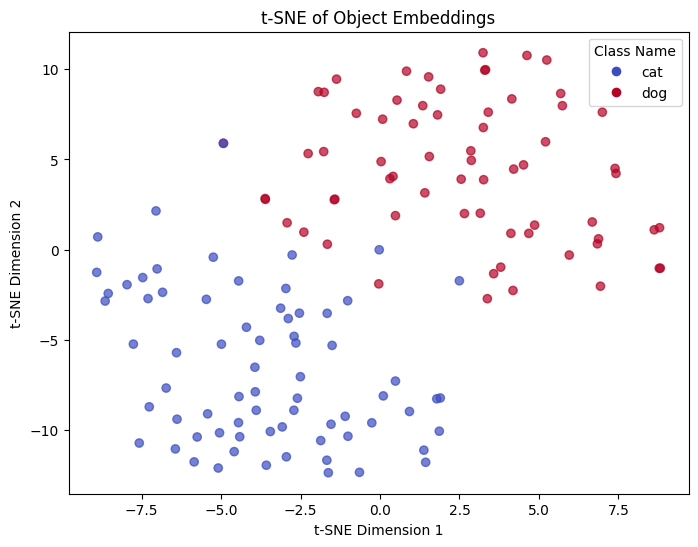

 Processed 138 embeddings after filtering.


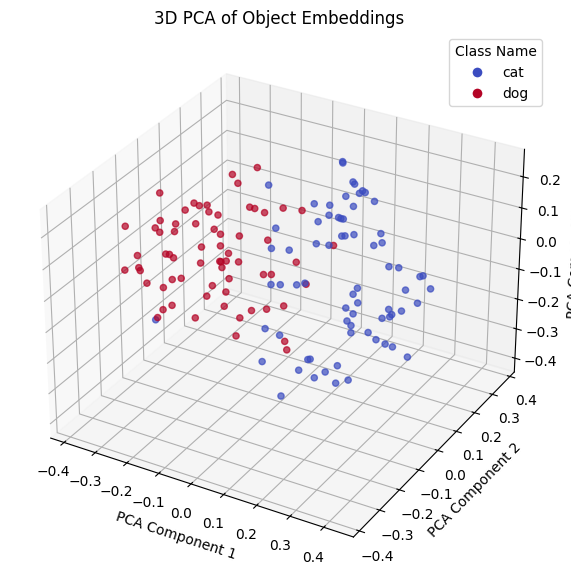

 Processed 35 images.
 Average processing time per image: 114.92 ms


In [16]:
# Initialize embedder
detector = "yolo12x" #replace to your relvany YOLO detector
embed_method= "crop"
crop_backbone="resnet50"
conf_threshold = 0.6 #yolo confidence threshold
# Logging parameters
logging.info(f"Detector: {detector}")
logging.info(f"Embedding Method: {embed_method}")
logging.info(f"Crop Backbone: {crop_backbone}")
logging.info(f"Confidence Threshold: {conf_threshold}")
# Initialize the embedder (with class filtering if needed)
embedder = ObjectEmbedder(detection_model=detector, target_classes=["dog", "cat"], conf_threshold=conf_threshold, embed_method=embed_method, crop_backbone=crop_backbone)  #Only visualize cats & dogs
evaluate_data(image_folder_path, embedder)

Croping Method with CLIP Encoder as Backbone

 Detector: yolo12x
 Embedding Method: crop
 Crop Backbone: clip
 Confidence Threshold: 0.6
YOLOv12x summary (fused): 283 layers, 59,135,744 parameters, 0 gradients, 199.0 GFLOPs


100%|███████████████████████████████████████| 338M/338M [00:10<00:00, 32.4MiB/s]


 Processed 138 embeddings after filtering.


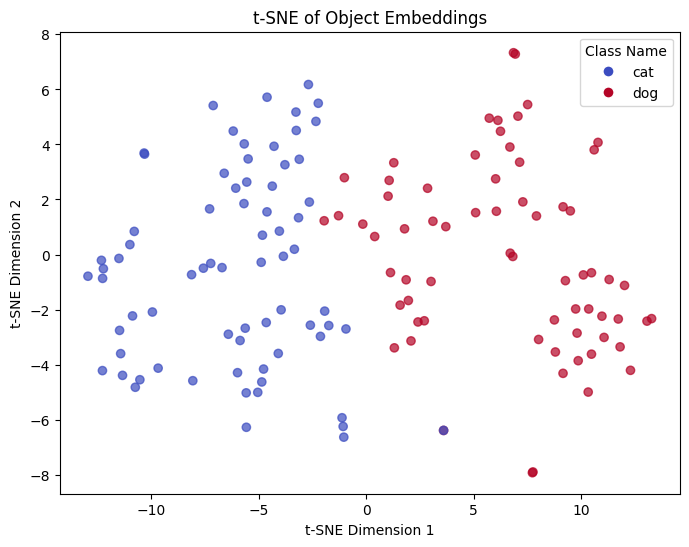

 Processed 138 embeddings after filtering.


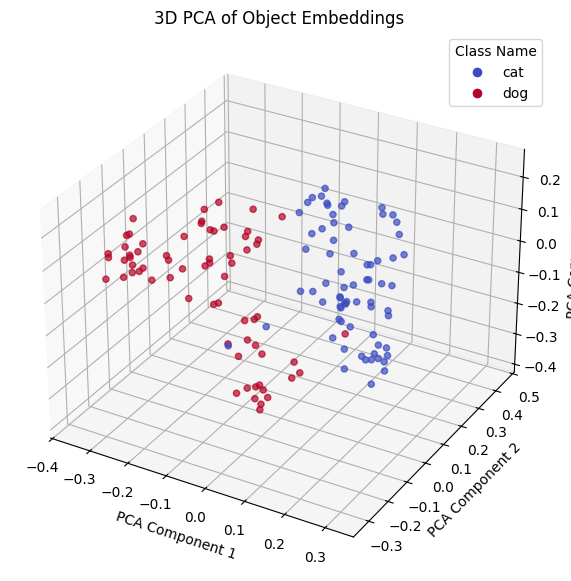

 Processed 35 images.
 Average processing time per image: 106.77 ms


In [17]:
# Initialize embedder
detector = "yolo12x" #replace to your relvany YOLO detector
embed_method= "crop"
crop_backbone="clip"
conf_threshold = 0.6 #yolo confidence threshold
# Logging parameters
logging.info(f"Detector: {detector}")
logging.info(f"Embedding Method: {embed_method}")
logging.info(f"Crop Backbone: {crop_backbone}")
logging.info(f"Confidence Threshold: {conf_threshold}")
# Initialize the embedder (with class filtering if needed)
embedder = ObjectEmbedder(detection_model=detector, target_classes=["dog", "cat"], conf_threshold=conf_threshold, embed_method=embed_method, crop_backbone=crop_backbone)  #Only visualize cats & dogs
# Process images in the folder and visualize embeddings
evaluate_data(image_folder_path, embedder)

ROI Align Method (optional, current results not sufficient)

 Detector: yolo12x
 Embedding Method: roi_align
 Confidence Threshold: 0.6
YOLOv12x summary (fused): 283 layers, 59,135,744 parameters, 0 gradients, 199.0 GFLOPs


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


 Processed 138 embeddings after filtering.


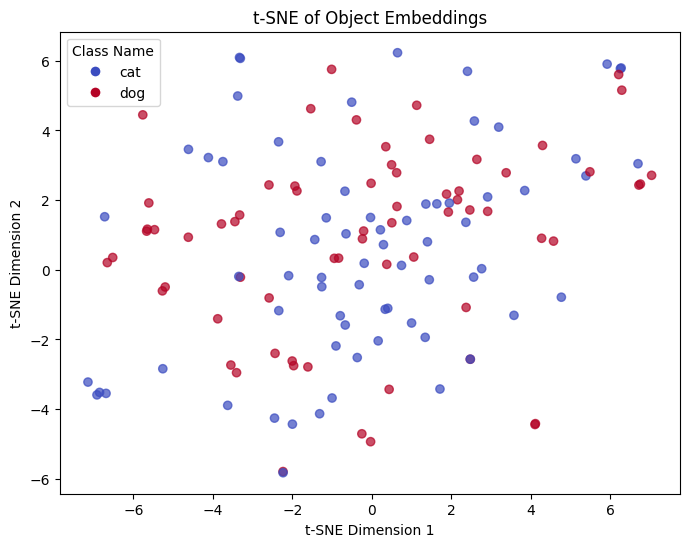

 Processed 138 embeddings after filtering.


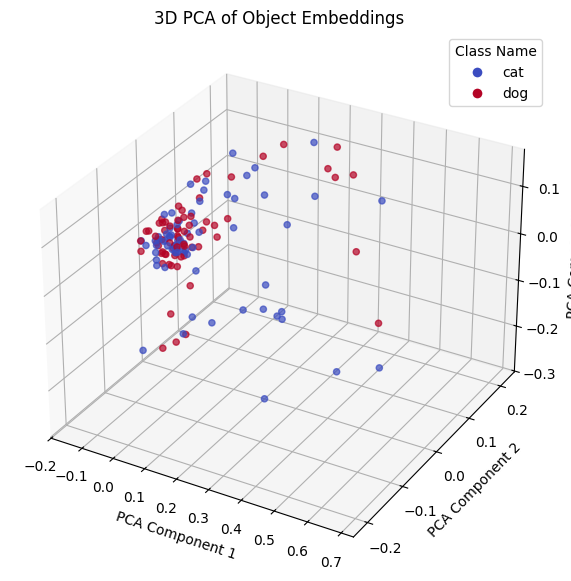

 Processed 35 images.
 Average processing time per image: 79.56 ms


In [18]:
# Initialize embedder
detector = "yolo12x" #replace to your relvany yolo detector
embed_method= "roi_align"
conf_threshold = 0.6 #yolo confidence threshold
# Logging parameters
logging.info(f"Detector: {detector}")
logging.info(f"Embedding Method: {embed_method}")
logging.info(f"Confidence Threshold: {conf_threshold}")
# Initialize the embedder (with class filtering if needed)# Initialize the embedder (with class filtering if needed)
embedder = ObjectEmbedder(detection_model=detector, target_classes=["dog", "cat"], conf_threshold=conf_threshold, embed_method=embed_method)  #Only visualize cats & dogs
# Process images in the folder and visualize embeddings
evaluate_data(image_folder_path, embedder)